In [43]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../src/")
import jax.numpy as jnp
import jax
import jax.tree_util as jtu
import genjax
from genjax import gen, Target, smc
from genjax import ChoiceMapBuilder as C
from config import *
from IPython.display import HTML, display, clear_output
genjax.pretty()

from maskcombinator_model import multifirefly_model
from utils import *

from constraints import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [44]:
def scatter_animation(observed_xs, observed_ys, gt_xs=None, gt_ys=None, fig=None, ax=None):
    """
    Basic scatter plot animation with moving points
    """
    # Create figure and axis
    if fig is None or ax is None:
        fig, ax = plt.subplots()

    ax.set_xlim(0, SCENE_SIZE)
    ax.set_ylim(SCENE_SIZE, 0)
    ax.set_title('Scatter Plot Animation')
    ax.set_facecolor("black")
    
    # Initialize scatter plot
    gt_scatter = ax.scatter([], [], edgecolors='g', facecolors=None, s=200, alpha=0.25, animated=True)
    obs_scatter = ax.scatter([], [], c='red', s=200, animated=True)

    # Animation update function
    def update(frame):
        if gt_xs is not None:
            xs = [x for x in gt_xs[frame, :] if x > -1]
            ys = [y for y in gt_ys[frame, :] if y > -1]
            if (len(xs) != len(ys)):    
                print(f"{frame}: Error - gt xs and ys have different shapes")
                print(xs, ys)
                
            gt_scatter.set_offsets(np.column_stack([xs, ys]))

            
        xs = [x for x in observed_xs[frame, :] if x > -1]
        ys = [y for y in observed_ys[frame, :] if y > -1]

        if(len(xs) != len(ys)):
            print(f"{frame}: Error - observed xs and ys have different shapes")
            print(xs, ys)
            
        # Update scatter plot data
        obs_scatter.set_offsets(np.column_stack([xs, ys]))

        return obs_scatter, gt_scatter
    
    # Create animation
    anim = animation.FuncAnimation(
        fig, 
        update, 
        frames=len(observed_xs),  # Number of animation frames
        interval=100,  # Milliseconds between frames
        blit=True
    )
    
    return anim

# Testing a different observation model

Make sure that the observation model is `get_observed_blinks` and not the pixel based model before running this notebook.

In [45]:
from maskcombinator_model import multifirefly_model

importance_jit = jax.jit(multifirefly_model.importance)

In [48]:
key = jax.random.PRNGKey(6432)
key, subkey = jax.random.split(key)
max_fireflies = jnp.arange(1, 3)

TIME_STEPS = 100
constraint = C["n_fireflies"].set(jnp.int32(2))
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS # Number of time steps to simulate
gt_tr, gt_w = importance_jit(subkey, constraint, (max_fireflies, time_mask,))
print(gt_w)
gt_chm = gt_tr.get_sample()
gt_chm

-0.6931472


Static({
  'init': {
    'blink_rate': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈0.1 ±0.0001 [≥0.1, ≤0.1] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'heading': Choice(
      v=Mask(value=<jax.Array float32(2,) ≈-2.6 ±0.0011 [≥-2.6, ≤-2.6] nonzero:2>, flag=<jax.Array bool(2,) true:2>),
    ),
    'vx': Choice(v=Mask(value=<jax.Array float32(2,) ≈0.71 ±0.24 [≥0.47, ≤0.94] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'vy': Choice(v=Mask(value=<jax.Array float32(2,) ≈-0.39 ±0.28 [≥-0.67, ≤-0.11] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'x': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.8e+01 ±0.095 [≥1.8e+01, ≤1.9e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
    'y': Choice(v=Mask(value=<jax.Array float32(2,) ≈1.5e+01 ±1.2e+01 [≥3.2, ≤2.7e+01] nonzero:2>, flag=<jax.Array bool(2,) true:2>)),
  },
  'steps': {
    'dynamics': {'blinking': Choice(v=Mask(value=<jax.Array bool(100, 2) true:17 false:183>, flag=<jax.Array bool(100, 2) true:200>)), 'heading': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈-2.6 ±0.75 [≥-4.1, ≤-1.3] nonzero:200>, flag=<jax.Array bool(100, 2) true:200>)), 'vx': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈-0.8 ±0.84 [≥-2.0, ≤1.5] nonzero:200>, flag=<jax.Array bool(100, 2) true:200>)), 'vy': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈-0.97 ±0.55 [≥-2.0, ≤0.31] nonzero:200>, flag=<jax.Array bool(100, 2) true:200>)), 'x': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈2.3e+01 ±7.5 [≥7.5, ≤3.2e+01] nonzero:200>, flag=<jax.Array bool(100, 2) true:200>)), 'y': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈2.5e+01 ±8.2 [≥3.2, ≤3.2e+01] nonzero:200>, flag=<jax.Array bool(100, 2) true:200>))},
    'observations': {'observed_xs': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈-7.1 ±9.7 [≥-1e+01, ≤3.2e+01] nonzero:200>, flag=<jax.Array bool(100,) true:100>)), 'observed_ys': Choice(v=Mask(value=<jax.Array float32(100, 2) ≈-7.0 ±1e+01 [≥-1e+01, ≤3.2e+01] nonzero:200>, flag=<jax.Array bool(100,) true:100>))},
  },
  'n_fireflies': Choice(v=<jax.Array(2, dtype=int32)>),
})

In [49]:
observed_xs, observed_ys = get_observations(gt_chm)
gt_xs, gt_ys = get_gt_locations(gt_chm)

anim = scatter_animation(observed_xs, observed_ys, gt_xs, gt_ys)
display(HTML(anim.to_jshtml()))
plt.close()

# Naive 1 vs. 2 importance sampling

In [208]:
# weights = []
# observed_xs, observed_ys = get_observations(gt_chm)

# for i in max_fireflies:
#     observations = set_observations(i, observed_xs, observed_ys, max_fireflies[-1]).simplify()
#     print("Number of Fireflies: ", i)
#     constraint = observations | C["n_fireflies"].set(jnp.int32(i))

#     key, subkey = jax.random.split(key)
#     tr, w = importance_jit(subkey, constraint, (max_fireflies, time_mask,))
#     weights.append(w)
#     obs_x, obs_y = get_observations(tr.get_sample())
#     gt_x, gt_y = get_gt_locations(tr.get_sample())

#     anim = scatter_animation(obs_x, obs_y, gt_x, gt_y)
#     display(HTML(anim.to_jshtml()))
#     print("Importance Weight: ", w)

#     plt.close()

# # Barplot for the importance weights
# plt.bar(max_fireflies, weights)
# plt.xticks(max_fireflies)
# plt.xlabel("Number of Fireflies")
# plt.ylabel("Importance Weight")
# plt.title("Importance Weights vs Number of Fireflies")
# plt.show()

# Let's try with constrained trajectories

In [209]:
vx = 1.
vy = 1.
x0 = 4.
y0 = 4.
x1 = x0 + vx * 2.
y1 = y0 + vy * 2.

chm = C["steps", 0, "dynamics", 0, "x"].set(jnp.float32(x0))
chm = chm | C["steps", 0, "dynamics", 0, "y"].set(jnp.float32(y0))
chm = chm | C["steps", 0, "dynamics", 0, "vx"].set(jnp.float32(vx))
chm = chm | C["steps", 0, "dynamics", 0, "vy"].set(jnp.float32(vy))
chm = chm | C["steps", 1, "dynamics", 0, "x"].set(jnp.float32(x1))
chm = chm | C["steps", 1, "dynamics", 0, "y"].set(jnp.float32(y1))

chm = chm | C["init", 0, "x"].set(jnp.float32(x0 - vx))
chm = chm | C["init", 0, "y"].set(jnp.float32(y0 - vy))
chm = chm | C["init", 0, "vx"].set(jnp.float32(vx)) 
chm = chm | C["init", 0, "vy"].set(jnp.float32(vy))

chm = chm | C["n_fireflies"].set(jnp.int32(1)) 
tr, w = importance_jit(subkey, chm, (jnp.array([1]), jnp.array([True, True]),))
print(tr.get_score())

-9980.641


In [240]:
from constraints import *
from maskcombinator_model import multifirefly_model

In [216]:
observed_xs, observed_ys = get_observations(gt_chm)

obs_x_single = single_firefly_observations(observed_xs)
obs_y_single = single_firefly_observations(observed_ys)

model = multifirefly_model
key = jax.random.PRNGKey(6342)
model_args = (max_fireflies, time_mask)

# Evaluate 1 vs. 2
constraint = C["n_fireflies"].set(jnp.int32(1))
constraints = get_trajectory_constraints(obs_x_single, obs_y_single, constraint)
tr_1, w_1 = importance_jit(key, constraints, model_args)

constraint = C["n_fireflies"].set(jnp.int32(2))
constraints = get_trajectory_constraints(observed_xs, observed_ys, constraint)
tr_2, w_2 = importance_jit(key, constraints, model_args)

print(w_1, w_2)

-1497.6976 160.97403


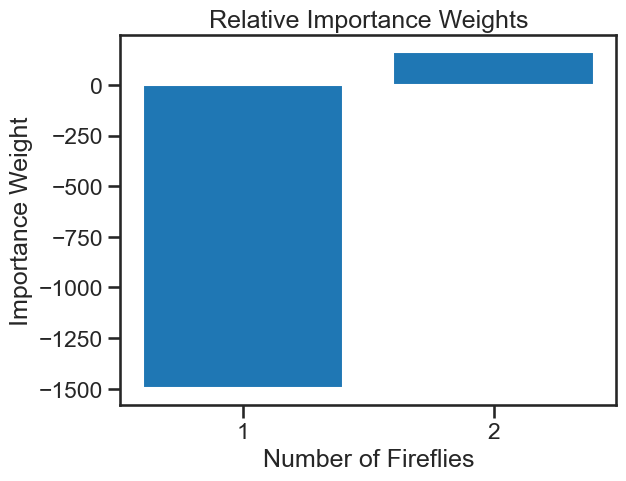

In [217]:
# Relative importance
plt.bar([1, 2], [w_1, w_2])
plt.xticks([1, 2])
plt.xlabel("Number of Fireflies")
plt.ylabel("Importance Weight")
plt.title("Relative Importance Weights")
plt.show()

In [218]:
tr_2.get_score()

<jax.Array(160.97403, dtype=float32)>

In [219]:
tr2_x, tr2_y = get_gt_locations(tr_2.get_sample())
anim = scatter_animation(observed_xs, observed_ys, tr2_x, tr2_y)
plt.title("Two Fireflies")
display(HTML(anim.to_jshtml()))
plt.close()

tr1_x, tr1_y = get_gt_locations(tr_1.get_sample())
observed_xs, observed_ys = get_observations(tr_1.get_sample())
anim = scatter_animation(observed_xs, observed_ys, tr1_x, tr1_y)
plt.title("One Firefly")
display(HTML(anim.to_jshtml()))

plt.close()

# Let's see if we can animate how our probabilities change over time

After each observation, evaluate the likelihood that it's 1 vs. 2 fireflies. Save the importance weights and animate the changes over time

In [281]:
# from maskcombinator_model import multifirefly_model
from constraints import *
# importance_jit = jax.jit(multifirefly_model.importance)

In [258]:
# observed_xs_test = jnp.array([4., 3.])
# observed_ys_test = jnp.array([4., 3.])

# c1 = C["n_fireflies"].set(jnp.int32(1))
# c1 = c1 | C["steps", 0, "observations", "observed_xs", :].set(observed_xs_test) 
# c1 = c1 | C["steps", 0, "observations", "observed_ys", :].set(observed_ys_test)
# c1 = c1 | C["steps", 0, "dynamics", :, "x"].set(observed_xs_test)
# c1 = c1 | C["steps", 0, "dynamics", :, "y"].set(observed_ys_test)
# c1 = c1 | C["steps", 0, "dynamics", :, "blinking"].set(jnp.array([True, True]))
# c1 = c1 | C["init", :, "x"].set(observed_xs_test)
# c1 = c1 | C["init", :, "y"].set(observed_ys_test)

# c2 = C["n_fireflies"].set(jnp.int32(2))
# c2 = c2 | C["steps", 0, "observations", "observed_xs", :].set(observed_xs_test) 
# c2 = c2 | C["steps", 0, "observations", "observed_ys", :].set(observed_ys_test)
# c2 = c2 | C["steps", 0, "dynamics", :, "x"].set(observed_xs_test)
# c2 = c2 | C["steps", 0, "dynamics", :, "y"].set(observed_ys_test)
# c2 = c2 | C["steps", 0, "dynamics", :, "blinking"].set(jnp.array([True, True]))
# c2 = c2 | C["init", :, "x"].set(observed_xs_test)
# c2 = c2 | C["init", :, "y"].set(observed_ys_test)

# tr, w1 = importance_jit(key, c1, (max_fireflies, jnp.array([True,]),))
# tr, w2 = importance_jit(key, c2, (max_fireflies, jnp.array([True,]),))
# print(w1, w2)


In [270]:
assess_jit = jax.jit(multifirefly_model.assess)

In [ ]:
from tqdm.notebook import tqdm

imp_weights = []
model_scores = []
observed_xs, observed_ys = get_observations(gt_chm)

obs_x_single = single_firefly_observations(observed_xs)
obs_y_single = single_firefly_observations(observed_ys)

num_observations = jnp.sum(obs_x_single > 0)
obs_indices, _ = jnp.where(obs_x_single > 0)

num_steps = len(observed_xs)

key = jax.random.PRNGKey(6342)

x1s_over_time = []
y1s_over_time = []
x2s_over_time = []
y2s_over_time = []


for t in tqdm(range(num_steps)):
    key, subkey = jax.random.split(key)
    key = subkey
    #    t = obs_indices[i]
    temporal_mask = jnp.arange(t + 1) < t + 1
    model_args = (max_fireflies, temporal_mask)
    constraint = C["n_fireflies"].set(jnp.int32(1))
    constraints = get_trajectory_constraints(obs_x_single[:t + 1], 
                                            obs_y_single[:t + 1], 
                                            constraint)
    
    tr, w_1 = importance_jit(key, constraints, model_args)
    score_1 = tr.get_score()
    # score_1, _ = assess_jit(tr.get_sample(), (max_fireflies, temporal_mask))

    x1, y1 = get_gt_locations(tr.get_sample())
    x1s_over_time.append(x1)
    y1s_over_time.append(y1)

    constraint = C["n_fireflies"].set(jnp.int32(2))
    constraints = get_trajectory_constraints(observed_xs[:t + 1], 
                                            observed_ys[:t + 1], 
                                            constraint)
    tr, w_2 = importance_jit(key, constraints, model_args)
    # score_2, _ = assess_jit(tr.get_sample(), (max_fireflies, temporal_mask))
    score_2 = tr.get_score()
    x2, y2 = get_gt_locations(tr.get_sample())
    x2s_over_time.append(x2)
    y2s_over_time.append(y2)

    imp_weights.append((w_1, w_2))
    model_scores.append((score_1, score_2))
    
    # plt.plot(x1, y1)
    # plt.scatter(obs_x_single[:t + 1], obs_y_single[:t + 1])
    # plt.title("One Firefly")
    # plt.xlim(0, SCENE_SIZE)
    # plt.ylim(SCENE_SIZE, 0)
    # plt.show()
    
    # for i in range(2):
    #     plt.plot(x2[:, i], y2[:, i])
    #     plt.scatter(observed_xs[:t + 1, i], observed_ys[:t + 1, i])

    # plt.xlim(0, SCENE_SIZE)
    # plt.ylim(SCENE_SIZE, 0)
    # plt.title("Two Fireflies")
    # plt.show()

    # fig, ax = plt.subplots()
    # anim = scatter_animation(obs_x_single[:t + 1], obs_y_single[:t + 1], x1, y1, fig, ax)
    # ax.set_title(f"t={t} : One Firefly")
    # display(HTML(anim.to_jshtml()))
    # plt.close()

    # fig, ax = plt.subplots()
    # anim = scatter_animation(observed_xs[:t + 1], observed_ys[:t + 1], x2, y2, fig, ax)
    # ax.set_title(f"t={t} : Two Fireflies")
    # display(HTML(anim.to_jshtml()))    
    # plt.close()

  0%|          | 0/30 [00:00<?, ?it/s]

In [283]:
import seaborn as sns
sns.set_style("dark")
sns.set_context("talk")
sns.set_style("ticks")

KeyboardInterrupt: 

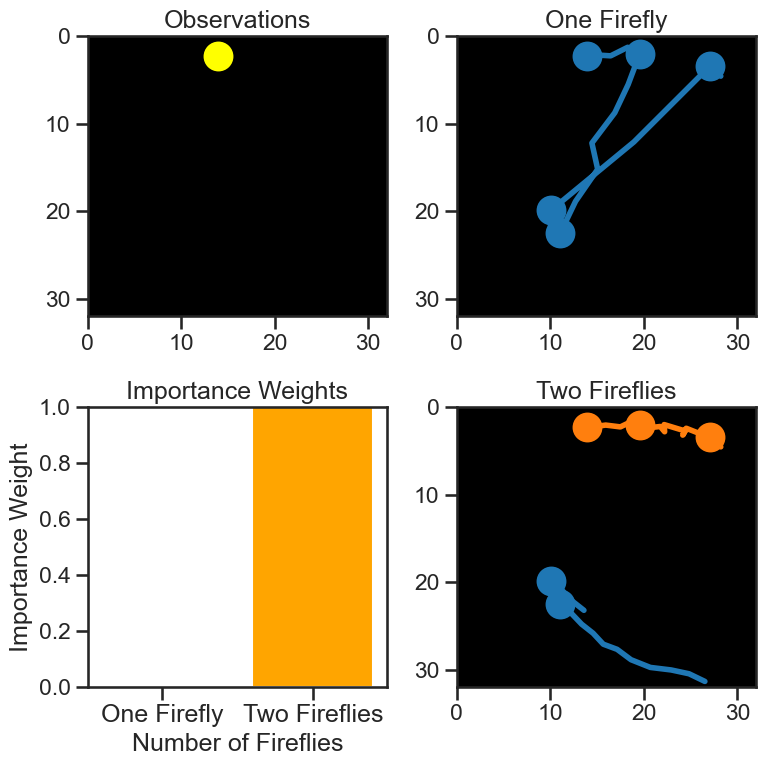

In [ ]:
# Create figure with three subplots: two for scenes and one for weights
fig = plt.figure(figsize=(8, 8))
ax1 = fig.add_subplot(222)  # One firefly scene
ax2 = fig.add_subplot(224)  # Two fireflies scene
ax3 = fig.add_subplot(223)  # Importance weights
ax4 = fig.add_subplot(221)  # Observations


# Scale importance weights to [0, 1]
imp_weights = jnp.array(imp_weights)
true_imp_weights = imp_weights.copy()
model_posterior_logprobs = jnp.array(model_scores)
# imp_weights = jnp.where(imp_weights == -jnp.inf, 0, imp_weights)

def update(frame):
    # Clear previous frame
    ax1.clear()
    ax2.clear()
    ax3.clear()
    ax4.clear()
    
    t = frame
    # Plot one firefly scene
    # Only plot first dimension for single firefly
    x1 = x1s_over_time[frame]
    y1 = y1s_over_time[frame]
    ax1.plot(x1[:t+1, 0], y1[:t+1, 0], linewidth=4)
    ax1.scatter(obs_x_single[:t + 1], obs_y_single[:t + 1], s=400)
    ax1.set_facecolor("black")
    ax1.set_title("One Firefly")
    ax1.set_xlim(0, SCENE_SIZE)
    ax1.set_ylim(SCENE_SIZE, 0)
    
    # Plot two fireflies scene
    x2 = x2s_over_time[frame]
    y2 = y2s_over_time[frame]
    for i in range(2):
        ax2.plot(x2[:t+1, i], y2[:t+1, i], linewidth=4)
        ax2.scatter(observed_xs[:t + 1, i], observed_ys[:t + 1, i], s=400)
    
    ax2.set_facecolor("black")
    ax2.set_title("Two Fireflies")
    ax2.set_xlim(0, SCENE_SIZE)
    ax2.set_ylim(SCENE_SIZE, 0)
    
    # Plot importance weights (log(p/q))
    logprobs = model_posterior_logprobs[frame]
    logprobs = jnp.where(logprobs == -jnp.inf, -1e-9, logprobs)
    weights = imp_weights[frame] 

    # Importance w/out proposal = P(x | y) / P(x)   
    # Assess under proposal for Q 

    # importance = p/q
    # normalize and exponentiate to get probabilities
    # probs = logprobs / jnp.sum(logprobs)
    ax3.bar([1, 2], weights, color=['blue', 'orange'])
    ax3.set_xticks([1, 2], labels=["One Firefly", "Two Fireflies"], fontsize=18)
    ax3.set_xlabel("Number of Fireflies")
    ax3.set_ylabel("Importance Weight")
    # ax3.set_ylim(jnp.min(jnp.array(imp_weights)), 0)
    ax3.set_ylim(0, 1)
    ax3.set_title("Importance Weights")
    
    # Plot observations
    obs_xs = obs_x_single[t - 1:t + 1]
    obs_ys = obs_y_single[t - 1:t + 1]
    ax4.scatter(obs_xs, obs_ys, c='yellow', s=400)
    ax4.set_facecolor("black")
    ax4.set_title("Observations")
    ax4.set_xlim(0, SCENE_SIZE)
    ax4.set_ylim(SCENE_SIZE, 0)

    # Adjust layout to prevent overlap
    plt.tight_layout()

# Create animation
fps = 5
ani = animation.FuncAnimation(
    fig, 
    update, 
    frames=num_steps,  # Use length of obs_indices for frames
    interval=1000/fps, 
    blit=False
)

ani.save("figures/1_vs_2_inference.mp4", fps=fps)
display(HTML(ani.to_jshtml()))
plt.close()

In [256]:
jnp.where(imp_weights == -jnp.inf)

(<jax.Array int32(2,) [≥14, ≤27] nonzero:2
   <Arrayviz rendering>
 | Device: CPU 0>,
 <jax.Array int32(2,) [≥1, ≤1] nonzero:2
   <Arrayviz rendering>
 | Device: CPU 0>)

# Test a 1 vs. 2 hand-designed scene

Fireflies travel in a line, and blink intermittently. If they blink close together and the prior on blink rate is low, the posterior on number should be higher.

The function below generates two choicemaps for a single scene. In one choicemap, all the blinks are assigned to a single firefly. In the second, the blinks are varied evenly between the two fireflies (both of which are traveling along the same path).

In [183]:
blink_interval = 3
TIME_STEPS = 30
single_firefly_chm, two_fireflies_chm, (xs, ys) = one_vs_two_blink_rate_dependent_inference(blink_interval, steps=TIME_STEPS, scene_size=32)

In [173]:
time_mask = jnp.arange(TIME_STEPS) < TIME_STEPS
max_fireflies = jnp.arange(1, 3)
single_tr, single_w = importance_jit(subkey, single_firefly_chm, (max_fireflies, time_mask,))
two_tr, two_w = importance_jit(subkey, two_fireflies_chm, (max_fireflies, time_mask,))

print(single_w, two_w)

-28495.162 -85123.875


### Visualization 

We can visualize the results -- both how it would look if there was one vs. two, and the respective importance weights of each proposed interpretation.

In [174]:
observed_xs, observed_ys = get_observations(single_tr.get_sample())
one_gt_x, one_gt_y = get_gt_locations(single_tr.get_sample())
two_gt_x, two_gt_y = get_gt_locations(two_tr.get_sample())

anim = scatter_animation(observed_xs, observed_ys, one_gt_x, one_gt_y)
plt.title("Single Firefly Interpretation")
display(HTML(anim.to_jshtml()))
plt.close()

observed_xs, observed_ys = get_observations(two_tr.get_sample())
anim = scatter_animation(observed_xs, observed_ys, two_gt_x, two_gt_y)
plt.title("Two Firefly Interpretation")
display(HTML(anim.to_jshtml()))
plt.close()

As we can see, just constraining on observations leaves our generative model to fill in the remaining values, and it often does so in a non-sensical way. To improve that, we'll need a proposal function to generate more coherent trajectories between 2 observed points. We'll import this code from `constraints.py`, and try again.

Now, given an assignment of observations to fireflies, we can generate and score more coherent trajectories.

In [185]:
from constraints import evaluate_trajectory_constraints
from utils import single_firefly_observations

model = multifirefly_model
args = (max_fireflies, time_mask)

# Evaluate Two firefly interpretation
constraints = C["n_fireflies"].set(jnp.int32(2))
observed_xs, observed_ys = get_observations(two_tr.get_sample())
tr_2, w_2, xs_2, ys_2 = evaluate_trajectory_constraints(model, args, observed_xs, observed_ys, constraints, scene_size=32.)
print(w_2)

# Evaluate Single firefly interpretation
constraints = C["n_fireflies"].set(jnp.int32(1))
observed_xs, observed_ys = get_observations(single_tr.get_sample())
tr_1, w_1, xs_1, ys_1 = evaluate_trajectory_constraints(model, args, observed_xs, observed_ys, constraints, scene_size=32.)
print(w_1)

-23042.336
-7646.881


In [ ]:
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def plot_firefly_trajectories(xs, ys, observed_xs, observed_ys, blinks, n_fireflies, scene_size=32):
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Create custom colormaps
    trajectory_cmap = plt.cm.viridis
    blink_cmap = plt.cm.RdYlBu
    
    for i in range(n_fireflies):
        # Create segments for the trajectory
        points = np.array([xs[:, i], ys[:, i]]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        # Create a time-based color array for the trajectory
        timesteps = np.linspace(0, 1, len(xs[:, i])-1)
        
        # Create the line collection with time-colored segments
        lc = LineCollection(segments, cmap=trajectory_cmap, alpha=0.7)
        lc.set_array(timesteps)
        line = ax.add_collection(lc)
        
        # Plot blinks with time-based colors
        timestep_colors = plt.cm.viridis(np.linspace(0, 1, len(xs[:, i])))
        blink_mask = blinks[:, i] == True  # Adjust threshold as needed

        # Plot non-blinking points
        ax.scatter(xs[~blink_mask, i], ys[~blink_mask, i],
                c=blinks[~blink_mask, i],
                cmap=blink_cmap,
                marker='.',
                alpha=0.7,
                s=300)

        # Plot blinking points
        scatter = ax.scatter(xs[blink_mask, i], ys[blink_mask, i],
                            c=blinks[blink_mask, i],
                            cmap=blink_cmap,
                            marker='x',
                            label=f'Firefly {i} blinks',
                            alpha=0.7,
                            s=350)

        
        # Plot observed points
        observed_mask = observed_xs[:, i] > -1
        ax.scatter(observed_xs[observed_mask, i],
                  observed_ys[observed_mask, i],
                  c='red',
                  label=f'Observed {i}' if i == 0 else "",
                  alpha=0.3,
                  s=300)
    
    # Add colorbars
    cbar_ax1 = fig.add_axes([-0.08, 0.1, 0.05, 0.8])  # [left, bottom, width, height]
    # Increase size of label
    trajectory_cbar = plt.colorbar(line, cax=cbar_ax1, label='Time', labelsize=12)


    # Set plot properties
    ax.set_xlim(0, scene_size)
    ax.set_ylim(scene_size, 0)  # Inverted y-axis
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_title('Firefly Trajectories with Time Coloring and Blink States')
    
    # Create a custom legend
    ax.legend(loc='center left', bbox_to_anchor=(1., 0.5))
    # Adjust layout to prevent cutting off elements
    plt.tight_layout()
    
    return fig, ax

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_92881/490178294.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


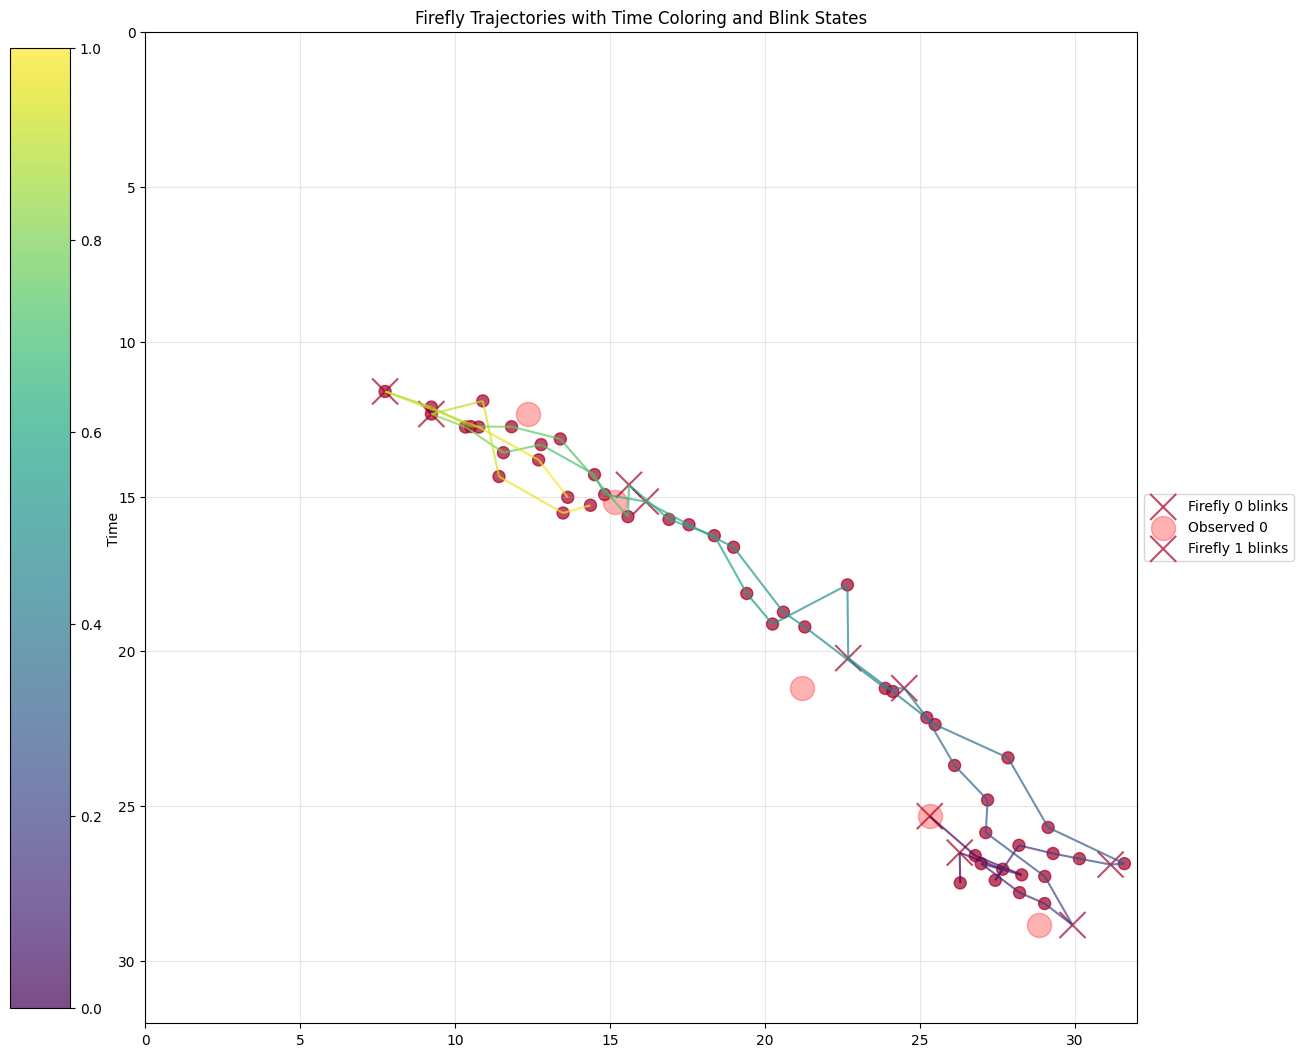

/var/folders/vz/qv2p5zmj48g74_wv3kzkjlmc0000gn/T/ipykernel_92881/490178294.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


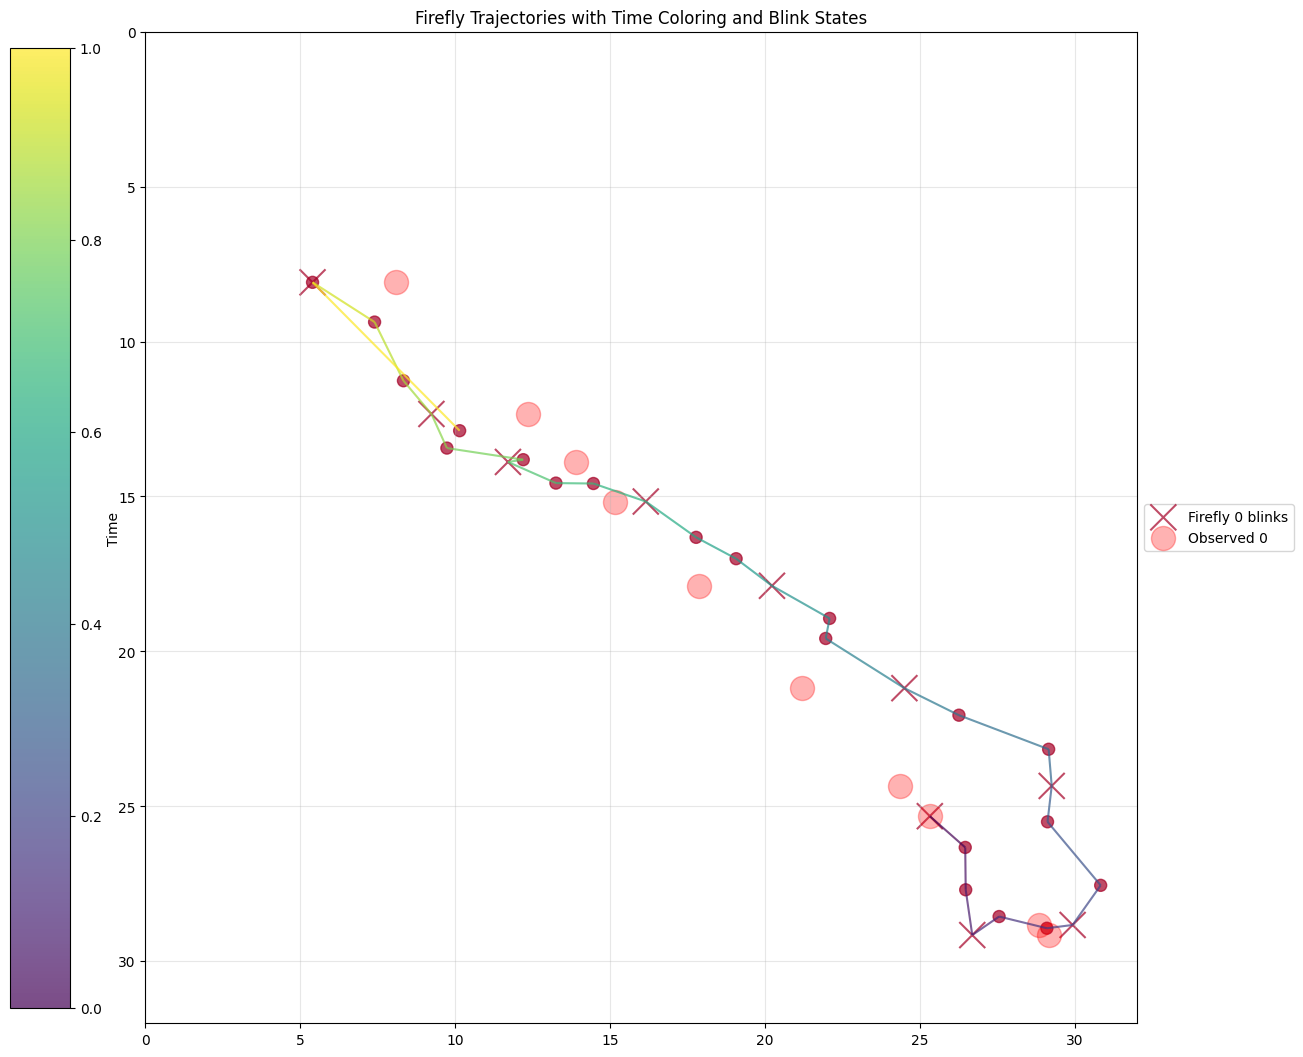

In [187]:
n_fireflies = tr_2.get_sample()["n_fireflies"]
blinks = tr_2.get_sample()["steps", :, "dynamics", :, "blinking"].value[:, :n_fireflies]
observed_xs, observed_xs = get_observations(tr_2.get_sample())
plot_firefly_trajectories(xs_2, ys_2, observed_xs, observed_ys, blinks, n_fireflies)
plt.show()

n_fireflies = 1
blinks = tr_1.get_sample()["steps", :, "dynamics", :, "blinking"].value[:, :n_fireflies]
observed_xs, observed_xs = get_observations(tr_1.get_sample())

plot_firefly_trajectories(xs_1, ys_1, observed_xs, observed_ys, blinks, n_fireflies)
plt.show()

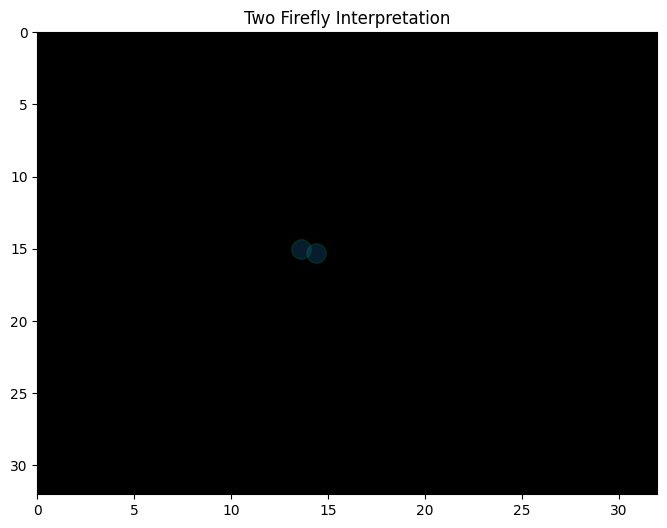

In [188]:
# animate both traces
obs_x_2, obs_y_2 = get_observations(tr_2.get_sample())
gt_x_2, gt_y_2 = get_gt_locations(tr_2.get_sample())

obs_x_1, obs_y_1 = get_observations(tr.get_sample())
gt_x_1, gt_y_1 = get_gt_locations(tr.get_sample())

anim_2 = scatter_animation(obs_x_2, obs_y_2, gt_x_2, gt_y_2)
plt.title("Two Firefly Interpretation")
display(HTML(anim_2.to_jshtml()))

anim_1 = scatter_animation(obs_x_1, obs_y_1, gt_x_1, gt_y_1)
plt.title("Single Firefly Interpretation")
display(HTML(anim_1.to_jshtml()))


plt.close()